# Image generation using CLIP and VQGAN - implementation with tricks

Now it's time to take our implementation and add tricks to make output image better.

In [1]:
# Image transformations
from torchvision import transforms

# Pytorch modules
import torch
from torch import nn, optim
from torch.nn import functional as F

# Misc for progress bar, saving and didplay
from tqdm.notebook import tqdm
from IPython import display
from PIL import ImageFile, Image

# All magic from basic notebook and advanced 1 notebook
from synth import *

In [2]:
device = get_device(use_gpu = True)

In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

CLIP_MODEL_FILEPATH = "weights/ViT-B-32.pt"
VQGAN_CONFIG_FILEPATH = "weights/wikiart_16384.yaml"
VQGAN_CHECKPOINT_FILEPATH = "weights/wikiart_16384.ckpt"

model_clip, clip_preprocessor = load_clip(CLIP_MODEL_FILEPATH, device)
model_vqgan = load_vqgan(VQGAN_CHECKPOINT_FILEPATH, VQGAN_CONFIG_FILEPATH, device, model_type="uncoditional_vqgan")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from weights/wikiart_16384.ckpt


## Advanced objective function

One way to improve quality of images is to agument the input to clip model. This will force the model to condi

In [4]:
def process_text_prompts(prompts, model_clip, device):
    output = []
    
    if not (prompts is None):
        for prompt, weight in prompts:
            t = clip.tokenize([prompt]).to(device)
            output.append((model_clip.encode_text(t).detach(), torch.tensor(weight, device=device)))
    
    return output

def process_image_prompts(prompts, model_clip, clip_preprocessor, device):
    output = []
    
    if not (prompts is None):
        for img, weight in prompts:
            img = clip_preprocessor(img).unsqueeze(0).to(device)
            output.append((model_clip.encode_image(img), torch.tensor(weight, device=device)))
    
    return output

class AdvancedObjective:
    def __init__(self, text_prompts, model_clip, device, agumenter, clip_preprocessor,
                 image_prompts = None,
                 exclude_text_prompts = None, exclude_image_prompts = None):
        
        self.text_embeddings = process_text_prompts(text_prompts, model_clip, device)
        self.image_embeddings = process_image_prompts(image_prompts, model_clip, clip_preprocessor, device)
        self.exclude_text_embeddings = process_text_prompts(exclude_text_prompts, model_clip, device)
        self.exclude_image_embeddings = process_image_prompts(exclude_image_prompts, model_clip, clip_preprocessor, device)
        self.device = device
        self.model = model_clip
        self.agumenter = agumenter
        
    def __call__(self, img):
        img = self.agumenter(img)
        img_encoding = self.model.encode_image(img)
        
        loss = torch.tensor(0.0, device=self.device)
        
        for embedding, weight in self.text_embeddings:
            loss += torch.cosine_similarity(img_encoding, embedding, -1).mean() * -1 * weight
            
        for embedding, weight in self.image_embeddings:
            loss += torch.cosine_similarity(img_encoding, embedding, -1).mean() * -1 * weight
        
        for embedding, weight in self.exclude_text_embeddings:
            loss += torch.cosine_similarity(img_encoding, embedding, -1).mean() * weight
            
        for embedding, weight in self.exclude_image_embeddings:
            loss += torch.cosine_similarity(img_encoding, embedding, -1).mean() * weight
        
        return loss

In [5]:
z = initialize_z(1024, 1024, model_vqgan, device)
z.requires_grad_(True)
opt = optim.Adam([z], lr=1e-1)

text_prompts = [("Abstract painting of colorfull geometry staircase.", 1.0)]

agumenter = Agumenter(device)
objective = AdvancedObjective(text_prompts, model_clip, device, agumenter, clip_preprocessor)

epoch: 1999, loss: -0.449462890625


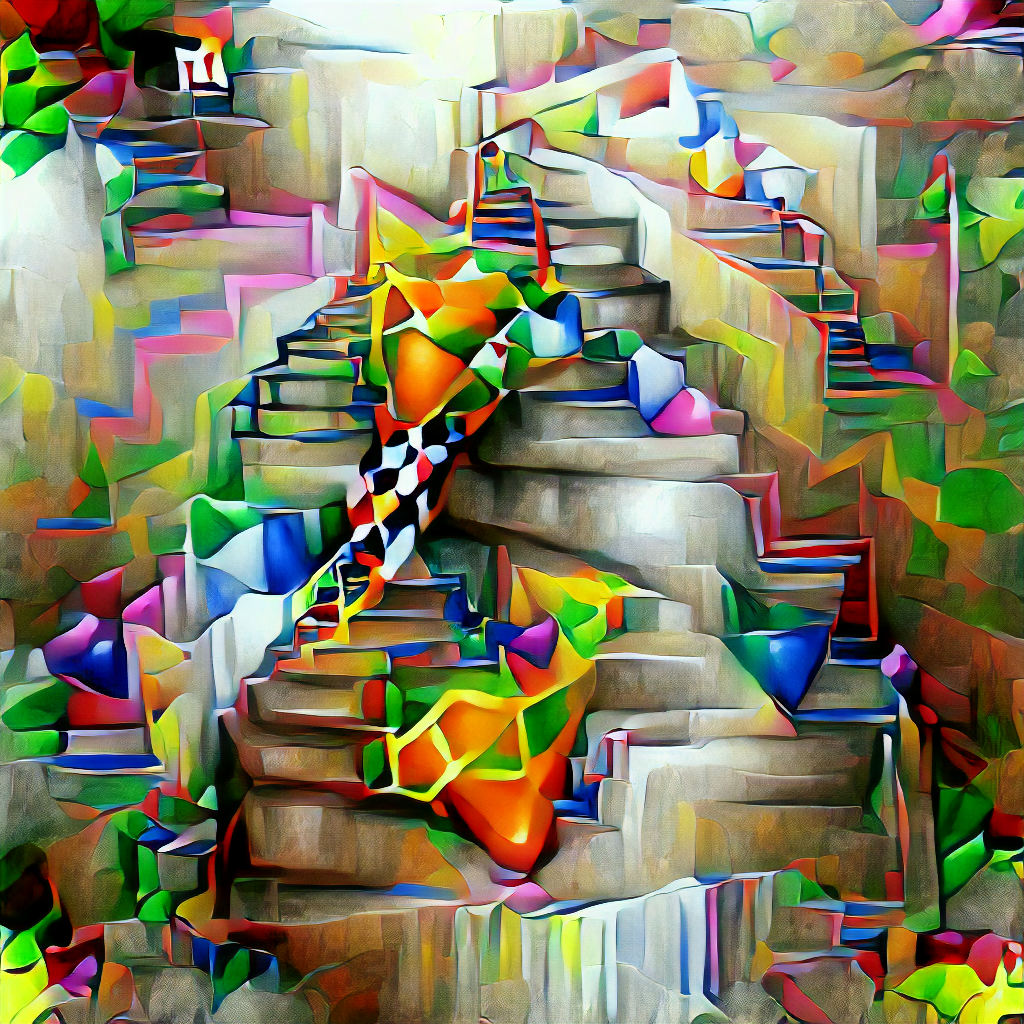

In [6]:
run(opt, z, objective, model_vqgan, model_clip,  2000)